# AI-Based Price Sensitivity Analyzer

This notebook presents a complete, step-by-step implementation of an AI-based system designed to analyze price sensitivity and optimize revenue using café sales data.


Install Required Librarie

In [1]:
pip install pandas numpy scikit-learn shap matplotlib seaborn

## Import Libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import shap
import matplotlib.pyplot as plt


## Load All Datasets



In [3]:
transactions = pd.read_csv("Cafe Transaction store.csv")
metadata = pd.read_csv("Cafe Sell MetaData.csv")
dateinfo = pd.read_csv("Cafe DateInfo.csv")

print(transactions.shape)
print(metadata.shape)
print(dateinfo.shape)


(5404, 5)
(11, 4)
(1349, 7)


## Convert Date Columns

In [4]:
transactions['CALENDAR_DATE'] = pd.to_datetime(transactions['CALENDAR_DATE'])
dateinfo['CALENDAR_DATE'] = pd.to_datetime(dateinfo['CALENDAR_DATE'])


/tmp/ipython-input-339781732.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  transactions['CALENDAR_DATE'] = pd.to_datetime(transactions['CALENDAR_DATE'])
/tmp/ipython-input-339781732.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dateinfo['CALENDAR_DATE'] = pd.to_datetime(dateinfo['CALENDAR_DATE'])


In [5]:
# Merge transactions with product metadata
df = transactions.merge(
    metadata,
    on=['SELL_ID', 'SELL_CATEGORY'],
    how='left'
)

# Merge with date information
df = df.merge(
    dateinfo,
    on='CALENDAR_DATE',
    how='left'
)

print(df.shape)
df.head()


(10840, 13)


,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,2012-01-01,15.50,46,1070,0,7821,BURGER,2012,New Year,1,0,24.8,0
1,2012-01-01,12.73,22,2051,2,7821,BURGER,2012,New Year,1,0,24.8,0
2,2012-01-01,12.73,22,2051,2,5030,COKE,2012,New Year,1,0,24.8,0
3,2012-01-01,12.75,18,2052,2,7821,BURGER,2012,New Year,1,0,24.8,0
4,2012-01-01,12.75,18,2052,2,6249,LEMONADE,2012,New Year,1,0,24.8,0


In [6]:
# Revenue
df['REVENUE'] = df['PRICE'] * df['QUANTITY']

# Log transformation (for elasticity)
df['LOG_PRICE'] = np.log(df['PRICE'])
df['LOG_QUANTITY'] = np.log(df['QUANTITY'])

# Handle missing values
df.fillna(0, inplace=True)


In [7]:
df[['PRICE', 'QUANTITY', 'REVENUE']].describe()


,PRICE,QUANTITY,REVENUE
count,10840.000000,10840.000000,10840.000000
mean,12.469232,39.928044,510.294400
std,1.332332,20.937454,318.769677
min,10.120000,8.000000,98.080000
25%,11.480000,24.000000,294.240000
50%,12.460000,34.000000,416.850000
75%,12.850000,50.000000,605.360000
max,16.500000,124.000000,1736.000000


In [8]:
X_elasticity = df[['LOG_PRICE']]
y_elasticity = df['LOG_QUANTITY']

elasticity_model = LinearRegression()
elasticity_model.fit(X_elasticity, y_elasticity)

elasticity = elasticity_model.coef_[0]
print("Price Elasticity of Demand:", round(elasticity, 3))


Price Elasticity of Demand: 1.472


In [9]:
features = [
    'PRICE',
    'IS_WEEKEND',
    'IS_SCHOOLBREAK',
    'AVERAGE_TEMPERATURE',
    'IS_OUTDOOR'
]

X = df[features]
y = df['QUANTITY']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("R2 Score:", round(r2_score(y_test, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))


R2 Score: 0.926
RMSE: 5.61


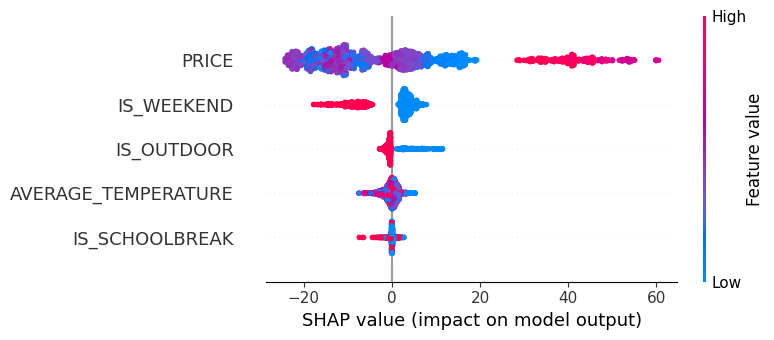

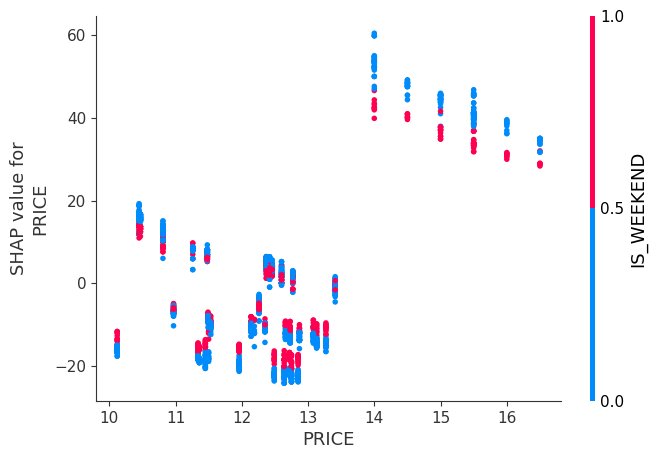

In [10]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Global importance
shap.summary_plot(shap_values, X_test)

# Price-specific impact
shap.dependence_plot("PRICE", shap_values, X_test)


In [11]:
price_range = np.linspace(df['PRICE'].min(), df['PRICE'].max(), 20)

base = X_test.mean().to_dict()
results = []

for p in price_range:
    base['PRICE'] = p
    predicted_qty = rf.predict(pd.DataFrame([base]))[0]
    revenue = p * predicted_qty
    results.append([p, predicted_qty, revenue])

sim_df = pd.DataFrame(
    results,
    columns=['PRICE', 'PREDICTED_DEMAND', 'REVENUE']
)

sim_df


,PRICE,PREDICTED_DEMAND,REVENUE
0,10.120000,26.312270,266.280175
1,10.455789,58.054925,607.010078
2,10.791579,59.079226,637.558132
3,11.127368,52.793556,587.453343
4,11.463158,26.622148,305.173888
5,11.798947,20.984516,247.595201
6,12.134737,29.694307,360.332600
7,12.470526,42.640767,531.752803
8,12.806316,47.011430,602.043212
9,13.142105,24.153333,317.425649


In [12]:
best = sim_df.loc[sim_df['REVENUE'].idxmax()]

print("Optimal Price:", round(best['PRICE'],2))
print("Expected Demand:", round(best['PREDICTED_DEMAND'],1))
print("Expected Revenue:", round(best['REVENUE'],2))


Optimal Price: 14.15
Expected Demand: 99.9
Expected Revenue: 1413.81


In [13]:
print(f"""
FINAL INSIGHTS:
- Price elasticity of demand is {round(elasticity,2)}
- Demand drops sharply beyond the optimal price
- Best price range maximizes revenue without losing customers
- Random Forest + SHAP provide explainable pricing strategy
""")



FINAL INSIGHTS:
- Price elasticity of demand is 1.47
- Demand drops sharply beyond the optimal price
- Best price range maximizes revenue without losing customers
- Random Forest + SHAP provide explainable pricing strategy



PICTORIAL OUTPUTS


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)


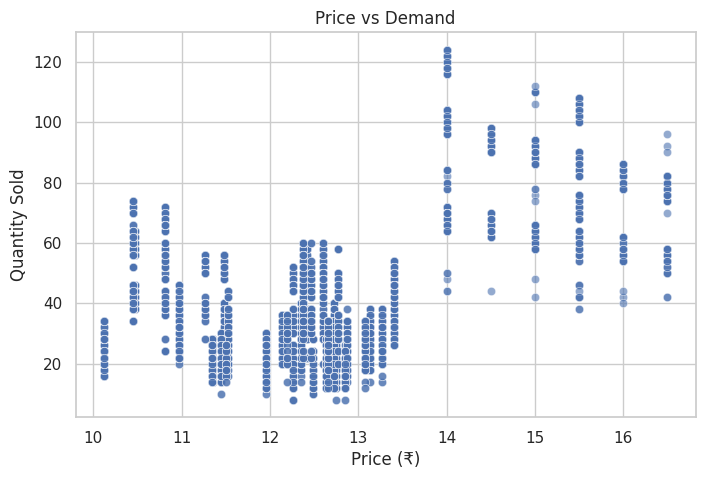

In [15]:
plt.figure()
sns.scatterplot(x=df['PRICE'], y=df['QUANTITY'], alpha=0.6)
plt.xlabel("Price (₹)")
plt.ylabel("Quantity Sold")
plt.title("Price vs Demand")
plt.show()


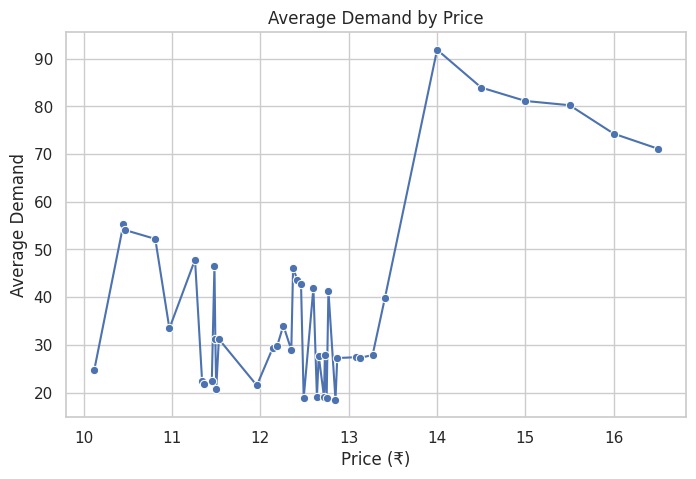

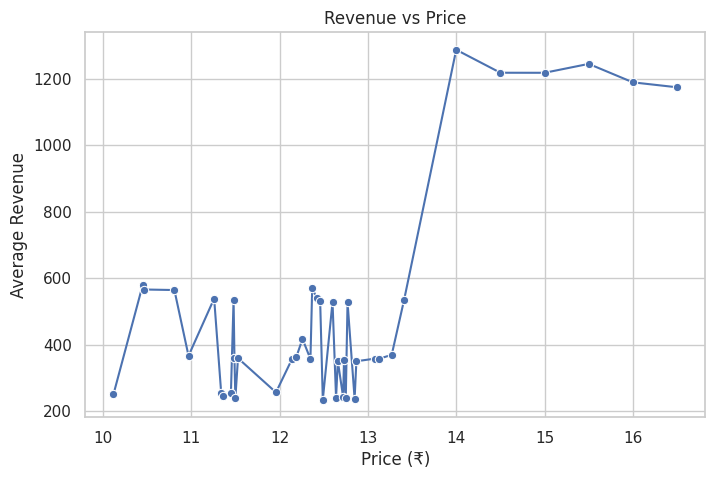

In [16]:
price_demand = df.groupby('PRICE')['QUANTITY'].mean().reset_index()

plt.figure()
sns.lineplot(x=price_demand['PRICE'], y=price_demand['QUANTITY'], marker='o')
plt.xlabel("Price (₹)")
plt.ylabel("Average Demand")
plt.title("Average Demand by Price")
plt.show()
revenue_price = df.groupby('PRICE')['REVENUE'].mean().reset_index()

plt.figure()
sns.lineplot(x=revenue_price['PRICE'], y=revenue_price['REVENUE'], marker='o')
plt.xlabel("Price (₹)")
plt.ylabel("Average Revenue")
plt.title("Revenue vs Price")
plt.show()


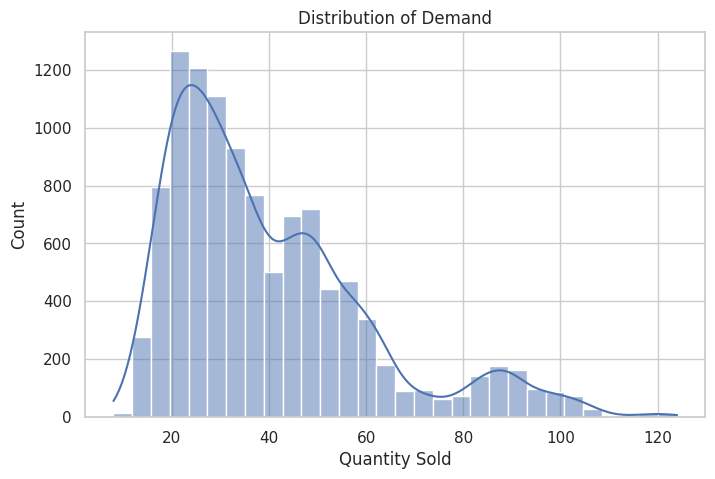

In [17]:
plt.figure()
sns.histplot(df['QUANTITY'], bins=30, kde=True)
plt.xlabel("Quantity Sold")
plt.title("Distribution of Demand")
plt.show()


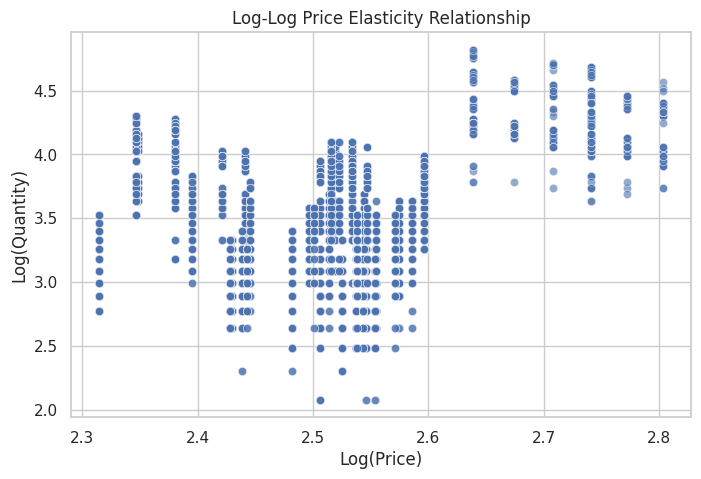

In [18]:
plt.figure()
sns.scatterplot(x=df['LOG_PRICE'], y=df['LOG_QUANTITY'], alpha=0.6)
plt.xlabel("Log(Price)")
plt.ylabel("Log(Quantity)")
plt.title("Log-Log Price Elasticity Relationship")
plt.show()


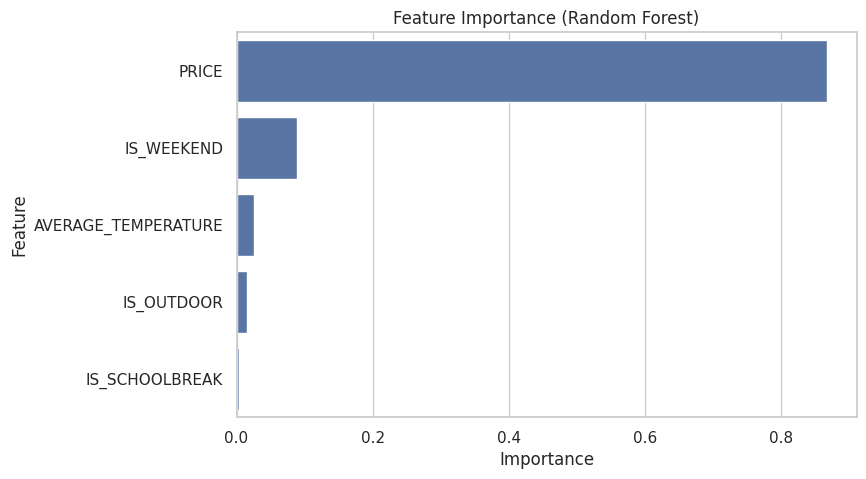

In [19]:
importances = rf.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure()
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance (Random Forest)")
plt.show()


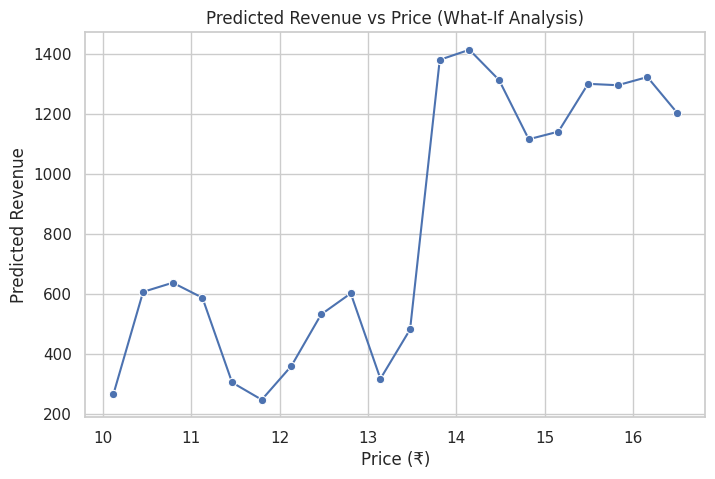

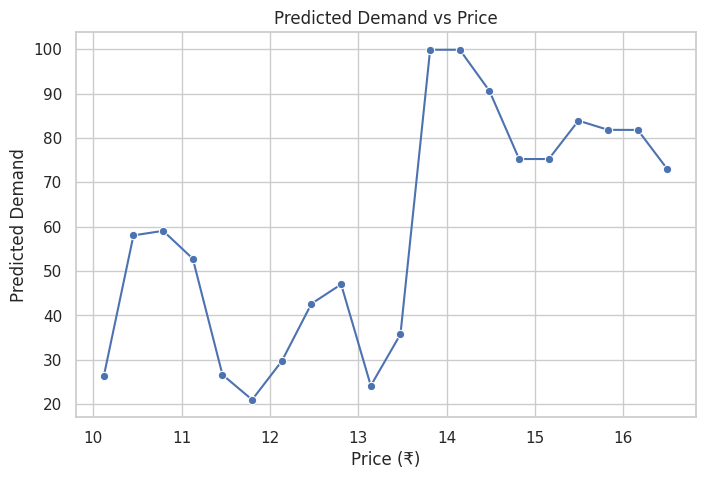

In [20]:
plt.figure()
sns.lineplot(x=sim_df['PRICE'], y=sim_df['REVENUE'], marker='o')
plt.xlabel("Price (₹)")
plt.ylabel("Predicted Revenue")
plt.title("Predicted Revenue vs Price (What-If Analysis)")
plt.show()
plt.figure()
sns.lineplot(x=sim_df['PRICE'], y=sim_df['PREDICTED_DEMAND'], marker='o')
plt.xlabel("Price (₹)")
plt.ylabel("Predicted Demand")
plt.title("Predicted Demand vs Price")
plt.show()
